# Setup Environment

In [3]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np # linear algebra
import pandas as pd #data processing, CSV file I/O
import os
import seaborn as sns # visualization

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

#Tackel warnings while running
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Load the data, have a brief look on their dimension

In [4]:
#Load back-up train set while keep the original train set untouched
train = pd.read_csv("./input/train-1.csv")
#Shape of the train set
print("Train shape : ", train.shape)
train.head()

Train shape :  (595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
#Load the test set
test = pd.read_csv("./input/test.csv")
#Shape of the train set
print("Test shape : ", test.shape)
test.head()

Test shape :  (892816, 58)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


# Split train and test data set

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb

id_train = train['id'].values
id_test = test['id'].values

#ps_car_03+05_cat have more than half of data with missing value. we remove them in advance.
X=train.drop(['id','target','ps_car_03_cat','ps_car_05_cat'], axis=1).values
x_test1=test.drop(['id','ps_car_03_cat','ps_car_05_cat'], axis=1).values

print('Train shape:', X.shape)
print('Test shape:', x_test1.shape)

y = train.target.values

xgbscores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

Train shape: (595212, 55)
Test shape: (892816, 55)


# Define the gini metric

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import lightgbm as lgb

# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

# Set xgb parameters for XGboost Classifier

In [8]:
# Set xgb parameters

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.03
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.85
params['colsample_bylevel'] = 0.9
#params['tree_method'] = 'exact'

In [16]:
# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

kfold = 3
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.25, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(x_test1)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)
    
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test)
    sub['target'] += p_test/kfold

# Create a submission file
sub.to_csv('xgb2.csv.gz', index=False,compression='gzip')

[Fold 1/3]
[0]	train-gini:0.226937	valid-gini:0.20384
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.305374	valid-gini:0.245667
[200]	train-gini:0.369401	valid-gini:0.267385
[300]	train-gini:0.420678	valid-gini:0.272559
Stopping. Best iteration:
[297]	train-gini:0.419479	valid-gini:0.272716

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-gini:0.224883	valid-gini:0.205572
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.303776	valid-gini:0.253615
[200]	train-gini:0.369624	valid-gini:0.274047
[300]	train-gini:0.41635	valid-gini:0.27928
Stopping. Best iteration:
[319]	train-gini:0.422582	valid-gini:0.279733

[Fold 2/3 Prediciton:]
[Fold 3/3]
[0]	train-gini:0.220863	valid-gini:0.214055
Multiple eval metrics have been passed: 'valid-gini' will be used for early stop

# XGboost+KFoldCV+SMOTE Resampling

In [9]:
import time
start = time.time()

from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, n_jobs=-1)

# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

kfold = 3
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.25, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    X_res, y_res = sm.fit_sample(X_train, y_train)
    print('Resampled dataset shape {}'.format(Counter(y_res)))
    # Convert our data into LGBoost format
    d_train = xgb.DMatrix(X_res, y_res)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(x_test1)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=40, feval=gini_xgb, maximize=True, verbose_eval=100)
    
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test)
    sub['target'] += p_test/kfold

# Create a submission file
sub.to_csv('xgb2.csv.gz', index=False,compression='gzip')

end = time.time()
runningtime = end - start
print('RunningTime=%.3fs'%(runningtime))

[Fold 1/3]
Resampled dataset shape Counter({0: 430138, 1: 430138})
[0]	train-gini:0.819637	valid-gini:0.059937
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 40 rounds.
[100]	train-gini:0.969182	valid-gini:0.155436
[200]	train-gini:0.971723	valid-gini:0.204034
[300]	train-gini:0.973905	valid-gini:0.237322
[400]	train-gini:0.97559	valid-gini:0.251648
[500]	train-gini:0.977123	valid-gini:0.256673
[600]	train-gini:0.978403	valid-gini:0.259127
[700]	train-gini:0.979574	valid-gini:0.260741
Stopping. Best iteration:
[727]	train-gini:0.979814	valid-gini:0.260808

[Fold 1/3 Prediciton:]
[Fold 2/3]
Resampled dataset shape Counter({0: 430138, 1: 430138})
[0]	train-gini:0.81756	valid-gini:0.045065
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 40 rounds.
Stopping. Best iteration:
[8]	train-gini:0.955904	valid-gini:0.134783

[

# Lets take a look on what the residue looks like for the validation & train-split set

(148803,)


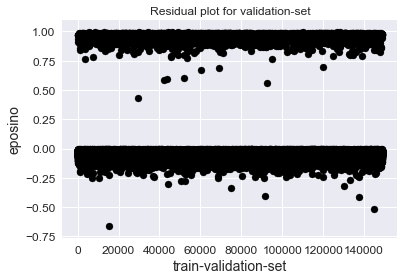

In [62]:
#residual plot for train-validation-set
id_train =np.arange(len(d_valid_pred))
d_valid_pred = mdl.predict(d_valid)
eposino=y_valid-d_valid_pred
print(eposino.shape)
plt.scatter(id_train, eposino, color='black')
plt.ylabel('eposino')
plt.xlabel('train-validation-set')
plt.title('Residual plot for validation-set')
plt.show()

(860278,)
(860278,)


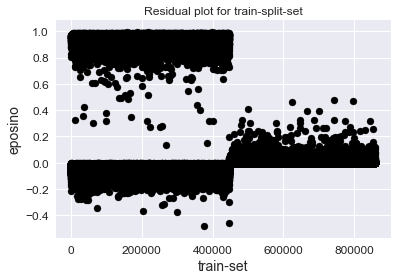

In [63]:
#residual plot for train-split-set
d_train_pred = mdl.predict(d_train)
id_train2 =np.arange(len(d_train_pred))
eposino=y_res-d_train_pred
print(eposino.shape)
print(id_train2.shape)
plt.scatter(id_train2, eposino, color='black')
plt.ylabel('eposino')
plt.xlabel('train-set')
plt.title('Residual plot for train-split-set')
plt.show()

In [66]:
for i in range(9):
    print (y_res[i*100000], d_train_pred[i*100000])

0 0.0385486
0 0.0220336
0 0.0241409
0 0.0406405
0 0.0223168
1 0.999993
1 0.999885
1 0.99707
1 0.999998


In [86]:
submission = pd.read_csv("./submission/xgb2.csv")
submission.head()
A=np.round(submission)
A.to_csv('xgb3.csv.gz', index=False,compression='gzip')

In [ ]:
len(submission['target'])

In [ ]:
submission.shape

In [ ]:
submission['target']

In [ ]:
np.round(submission)